In [1]:
import os
os.chdir("../../")

In [2]:
try:
  import GPy
except ModuleNotFoundError:
  %pip install GPy
  import GPy

In [3]:
from probml_utils.blackjax_utils import inference_loop
import blackjax

In [4]:
import flax
from flax import linen as nn
from flax.core import unfreeze

import jax
import jax.numpy as jnp
import optax
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import regression_data
import tensorflow_probability.substrates.jax as tfp

from models.gaussian_mlp import gmlp 
from models.mlp import mlp 
from utilities.fits import fit
from utilities.gmm import gmm_mean_var
from utilities.predict import predict
from utilities import plot

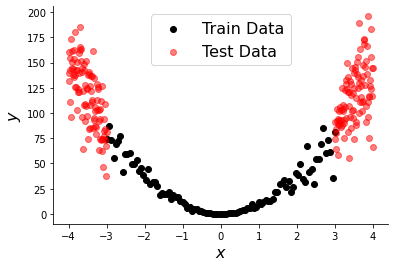

In [5]:
x_train,y_train, x_test, y_test = regression_data.data_set()
x_linspace_test= jnp.linspace(-4, 4, 300).reshape(-1,1)
plot.plot_actualdata(x_train,y_train,x_test, y_test)

## MLP

In [6]:
mlp_model = mlp([32, 64, 32, 1],[nn.relu]*3,[0]*3)
mlp_params = mlp_model.init(jax.random.PRNGKey(0), x_train, True)

In [7]:
mlp_params, mlp_loss = fit(mlp_model, mlp_params,x_train,y_train, True, learning_rate= 0.001, epochs=1000)

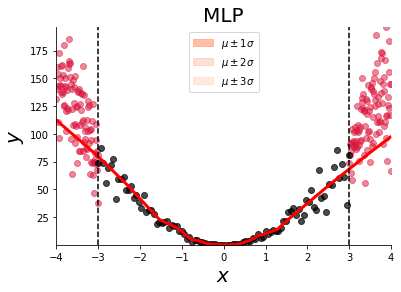

In [8]:
n_points =300
y_hat = mlp_model.apply(mlp_params, x_linspace_test, True)
y_hat_train = mlp_model.apply(mlp_params,x_train,True)
y_hat_test = mlp_model.apply(mlp_params,x_test,True)
y_hat = y_hat.reshape(n_points)
plot.plot_prediction_reg(x_train,y_train,x_test,y_test,x_linspace_test,y_hat,0,"MLP")


In [9]:
y_hat_train.reshape(-1).shape

(100,)

Gaussian MLP

In [10]:
gmlp_model = gmlp(features=[32, 32], activations=[nn.relu]*2, dropout_rate=[0.03]*2)

In [11]:
gmlp_params = gmlp_model.init(jax.random.PRNGKey(100), x_train, True)

In [12]:
gmlp_params, loss = fit(gmlp_model, gmlp_params, x_train,y_train,deterministic=True,learning_rate=0.003, epochs=2000)

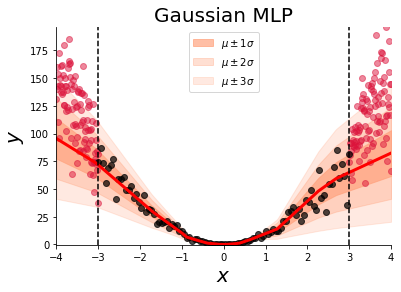

In [13]:
gmlp_mean, gmlp_sigma = gmlp_model.apply(gmlp_params, x_linspace_test, True)

plot.plot_prediction_reg(x_train,y_train,x_test,y_test,x_linspace_test,gmlp_mean,gmlp_sigma,"Gaussian MLP")

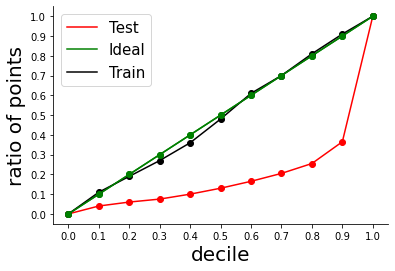

In [14]:
fig,ax=plt.subplots(1)
gmlp_mean_test,gmlp_sigma_test=gmlp_model.apply(gmlp_params, x_test, True)
gmlp_mean_train,gmlp_sigma_train = gmlp_model.apply(gmlp_params, x_train, True)
_,_=plot.calibration_regression(gmlp_mean_test,gmlp_sigma_test,y_test,'Red','Test',ax)
_,_=plot.calibration_regression(gmlp_mean_train,gmlp_sigma_train,y_train,'black','Train',ax)

## MC Dropout Gaussian MLP

In [15]:
n_stacks = 100
fn = lambda x,i : gmlp_model.apply(gmlp_params, x, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)})
y_stacks = jax.vmap(fn, in_axes=(None,0))(x_linspace_test,jnp.arange(n_stacks))
mean_stacks = y_stacks[0]
sigma_stacks = y_stacks[1]
mc_mean, mc_sigma = gmm_mean_var(mean_stacks, sigma_stacks)





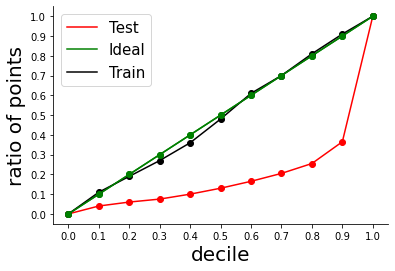

In [16]:
y_stacks = jax.vmap(fn, in_axes=(None,0))(x_test,jnp.arange(n_stacks))
mean_stacks = y_stacks[0]
sigma_stacks = y_stacks[1]
mc_mean_test, mc_sigma_test = gmm_mean_var(mean_stacks, sigma_stacks)
fig,ax=plt.subplots(1)
gmlp_mean_test,gmlp_sigma_test=gmlp_model.apply(gmlp_params, x_test, True)
gmlp_mean_train,gmlp_sigma_train = gmlp_model.apply(gmlp_params, x_train, True)
_,_=plot.calibration_regression(gmlp_mean_test,gmlp_sigma_test,y_test,'Red','Test',ax)
_,_=plot.calibration_regression(gmlp_mean_train,gmlp_sigma_train,y_train,'black','Train',ax)

In [ ]:
fig,ax=plt.subplots(1)
gmlp_mean_test,gmlp_sigma_test=gmlp_model.apply(gmlp_params, x_test, True)
gmlp_mean_train,gmlp_sigma_train = gmlp_model.apply(gmlp_params, x_train, True)
_,_=plot.calibration_regression(gmlp_mean_test,gmlp_sigma_test,y_test,'Red','Test',ax)
_,_=plot.calibration_regression(gmlp_mean_train,gmlp_sigma_train,y_train,'black','Train',ax)

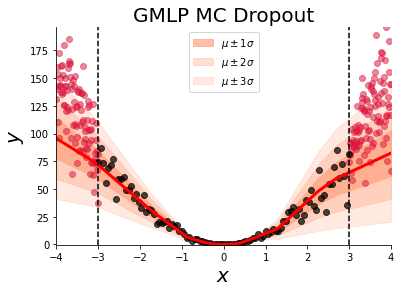

In [17]:
mc_mean, mc_sigma= mc_mean.reshape(n_points),mc_sigma.reshape(n_points)
plot.plot_prediction_reg(x_train,y_train,x_test,y_test,x_linspace_test,mc_mean,mc_sigma,"GMLP MC Dropout")

## Deep Ensemble Gaussian MLP

In [18]:
params_list = []
losses_list = []
n_models = 5
for i in range(n_models):
    params = gmlp_model.init(jax.random.PRNGKey(i), x_train, deterministic = True)
    params, loss =  fit(gmlp_model, params, x_train,y_train,deterministic=True, learning_rate=0.003, epochs=2000)
    params_list.append(params)
    losses_list.append(loss)


In [19]:
means_list,sigmas_list = predict(n_models, gmlp_model, params_list, x_linspace_test)
de_mean, de_sigma = gmm_mean_var(means_list,sigmas_list)
means_list,sigmas_list = predict(n_models, gmlp_model, params_list, x_test)
de_mean_test, de_sigma_test= gmm_mean_var(means_list,sigmas_list)
means_list,sigmas_list = predict(n_models, gmlp_model, params_list, x_train)
de_mean_train, de_sigma_train = gmm_mean_var(means_list,sigmas_list)


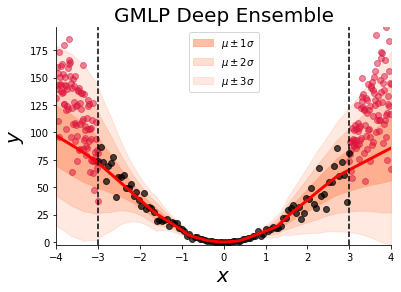

In [20]:
de_mean, de_sigma = de_mean.reshape(n_points),de_sigma.reshape(n_points)
plot.plot_prediction_reg(x_train,y_train,x_test,y_test,x_linspace_test,de_mean,de_sigma,"GMLP Deep Ensemble")

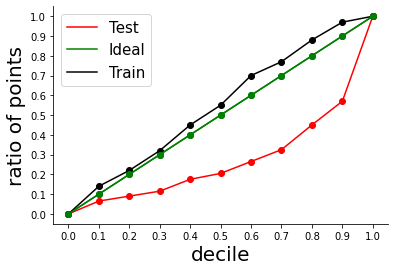

In [21]:
fig,ax=plt.subplots(1)
_,_=plot.calibration_regression(de_mean_test,de_sigma_test,y_test,'Red','Test',ax)
_,_=plot.calibration_regression(de_mean_train,de_sigma_train,y_train,'black','Train',ax)

In [22]:
key = jax.random.PRNGKey(42)
sigmaf = 5.0
len_scale =  3.0
kernel = GPy.kern.RBF(1, sigmaf, len_scale)



In [23]:
# %%capture
model_gp = GPy.models.GPRegression(x_train, y_train, kernel, normalizer=False) 
model_gp.Gaussian_noise = 1.0
model_gp.optimize(messages=True)
model_gp.optimize_restarts(num_restarts=5)



 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 354.2583923339844
Optimization restart 2/5, f = 387.4093933105469
Optimization restart 3/5, f = 354.2583923339844
Optimization restart 4/5, f = 378.03350830078125
Optimization restart 5/5, f = 372.48406982421875


In [24]:
# %%capture
mu_gp, cov_gp = model_gp.predict(x_linspace_test)
mu_gp_train, cov_gp_train = model_gp.predict(x_train)
mu_gp_test, cov_gp_test= model_gp.predict(x_test)
mu_gp=mu_gp.reshape(n_points)
sigma_gp= jnp.sqrt(cov_gp).reshape(n_points)


 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning:Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.


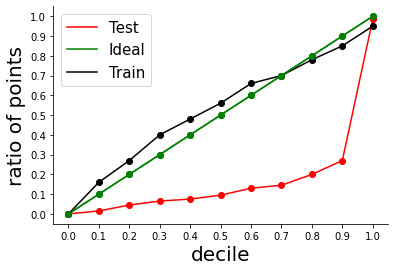

In [25]:
fig,ax=plt.subplots(1)
_,_=plot.calibration_regression(mu_gp_test.reshape(-1),jnp.sqrt(cov_gp_test).reshape(-1),y_test,'Red','Test',ax)
_,_=plot.calibration_regression(mu_gp_train.reshape(-1),jnp.sqrt(mu_gp_train).reshape(-1),y_train,'black','Train',ax)

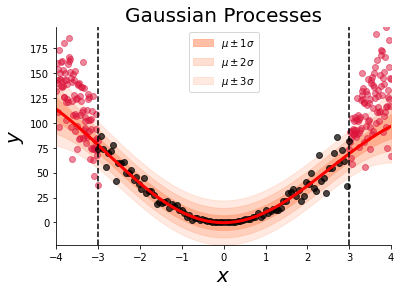

In [26]:
plot.plot_prediction_reg(x_train,y_train,x_test,y_test,x_linspace_test,mu_gp,sigma_gp,"Gaussian Processes")

In [27]:
from jax import tree_map 
from jax.flatten_util import ravel_pytree
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from functools import partial

In [28]:
def bnn_log_joint(params, X, y, model):
    mean,sigma = model.apply(params, X,deterministic=True)
    
    flatten_params, _ = ravel_pytree(params)
    log_prior = tfd.Normal(0.0, 1.0).log_prob(flatten_params).sum()
    # log_likelihood = tfd.Bernoulli(logits=logits).log_prob(y).sum()
    log_likelihood = tfd.Normal(mean,sigma).log_prob(y.reshape((-1,))).sum()
    log_joint = log_prior + log_likelihood
    return log_joint

bnn_log_joint_partial =partial(bnn_log_joint,X=x_train,y=y_train,model=gmlp_model)
bnn_log_joint_partial(params)

DeviceArray(-1716.7766, dtype=float32)

In [29]:
num_warmup = 3000
potential = bnn_log_joint_partial
key = jax.random.PRNGKey(314)
key_samples, key_init, key_warmup, key = jax.random.split(key, 4)
adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
final_state, kernel, _ = adapt.run(key_warmup, params)
num_samples = 1000
states,infos = inference_loop(key_samples, kernel, final_state, num_samples)

In [33]:
def x_one_step(x):
    def one_step(carry, state):
        params_cur = state.position
        mean,sigma = gmlp_model.apply(params_cur,x,deterministic=True)
        return carry, (mean,sigma)
    return(one_step)

one_step_lin = x_one_step(x_linspace_test)
one_step_test = x_one_step(x_test)
one_step_train= x_one_step(x_train)
_, (mean_stacks,sigma_stacks) = jax.lax.scan(one_step_lin, None, states)
_,(mean_stacks_test,sigma_stacks_test) =jax.lax.scan(one_step_test, None, states)
_,(mean_stacks_train,sigma_stacks_train) =jax.lax.scan(one_step_train, None, states)

In [34]:
mean_mcmc,sigma_mcmc = gmm_mean_var(mean_stacks, sigma_stacks)
mean_mcmc_test,sigma_mcmc_test = gmm_mean_var(mean_stacks_test, sigma_stacks_test)
mean_mcmc_train,sigma_mcmc_train = gmm_mean_var(mean_stacks_train, sigma_stacks_train)

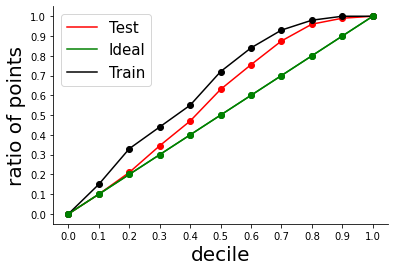

In [35]:
fig,ax=plt.subplots(1)
_,_=plot.calibration_regression(mean_mcmc_test,sigma_mcmc_test,y_test,'Red','Test',ax)
_,_=plot.calibration_regression(mean_mcmc_train,sigma_mcmc_train,y_train,'black','Train',ax)

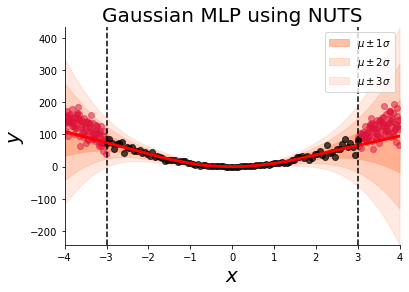

In [32]:
plot.plot_prediction_reg(x_train,y_train,x_test,y_test,x_linspace_test,mean_mcmc,sigma_mcmc,"Gaussian MLP using NUTS")